In [1]:
%%capture
!pip install transformers
!pip install -U sentence-transformers
!pip install datasets
!pip install evaluate
!pip install googletrans==3.1.0a0

from google.colab import drive
drive.mount('/content/drive')

Load the dataset and remove string noise

In [2]:
import pandas as pd

recipes = pd.read_csv("/content/drive/MyDrive/Semantics In Intelligent Information Access/dataset_covered_recipes.csv", 
                          delimiter=';', 
                          quotechar='"', 
                          header=0, 
                          index_col = 0)

recipes = recipes.rename(columns={"SUSTAINABILITY": "sustainability"})
recipes['sustainability'] = recipes['sustainability'].str.lower()

# remove empty rows
# recipes = recipes[recipes["sustainability"].astype(str).str.len() != 0]
recipes = recipes.dropna(subset=['sustainability'])
display(recipes.head())

valori_unici = recipes['sustainability'].unique()
print('\n',valori_unici)

,title,url,ingredients,sustainability
recipe_id,,,,
39637,Sally's Coleslaw Dressing Recipe,http://cookeatshare.com/recipes/sally-s-colesl...,cabagge,high
28634,Canning Pumpkin,http://www.food.com/recipe/canning-pumpkin-395684,pumpkin,high
2427,Pumpkin Puree,http://cooking.nytimes.com/recipes/4333,pumpkin,high
19530,Grilled ORE-IDA Roasted Original Potatoes,http://www.kraftrecipes.com/recipes/grilled-or...,potato,high
7258,Baked Potato Toppings Recipe,http://cookeatshare.com/recipes/baked-potato-t...,potato,high



 ['high' 'medium' 'low']


In [3]:
import numpy as np

rec_perc = recipes.loc[:, ["title","ingredients", "sustainability"]].copy()
# rec_perc['text'] = rec_perc['title'] + ' ' + rec_perc['ingredients']
rec_perc['text'] = rec_perc['ingredients']
rec_perc.drop(['title', 'ingredients'], axis=1, inplace=True)
rec_perc.rename(columns={'sustainability': 'label'}, inplace=True)
rec_ft = rec_perc

sustainability
high       6323
low         720
medium    16459
dtype: int64

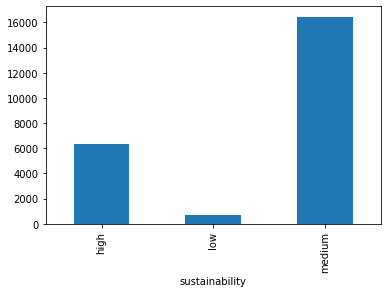

In [4]:
recipes.groupby("sustainability").size().plot.bar()
recipes.groupby("sustainability").size()

label
0     6323
1      720
2    16459
dtype: int64

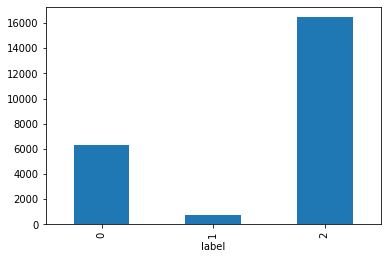

In [5]:
rec_ft.reset_index(drop=True, inplace=True)
rec_ft['label'] = pd.Categorical(rec_ft['label']).codes

rec_ft.groupby("label").size().plot.bar()
rec_ft.groupby("label").size()

# Model are able to learn (and classify)

In [6]:
from transformers import pipeline, set_seed
from datasets import Dataset, DatasetDict

import numpy as np
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer

set_seed(42)

# create an array with the indices of the examples in the DataFrame
indices = np.arange(len(rec_ft))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# create a boolean mask to select the examples in train and test
train_mask = np.isin(indices, train_indices)
test_mask = np.isin(indices, test_indices)

# create the train and test DataFrames using the masks
train_data = rec_ft[train_mask]
test_data = rec_ft[test_mask]

# group the train and test data by label
train_grouped = train_data.groupby('label')
test_grouped = test_data.groupby('label')

# sample the examples for each group (i.e., class) without replacement using the indices
train_examples = []
test_examples = []
for name, group in train_grouped:
    train_examples.append(group.sample(n=480, random_state=42))
for name, group in test_grouped:
    test_examples.append(group.sample(n=120, random_state=42))

# concatenate the examples into train and test DataFrames
train_data = pd.concat(train_examples)
test_data = pd.concat(test_examples)

train_dataset = Dataset.from_pandas(train_data)#, split='train')
test_dataset = Dataset.from_pandas(test_data)

dataset_1 = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# tokenize dataset
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", max_length=100, truncation=True)

tokenized_datasets = dataset_1.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [7]:
train_data.head()

,label,text
2417,0,"cabagge,red pepper or cayenne spices,ketchup,b..."
5387,0,"apple juice,oat meal"
3460,0,rice
4029,0,"pumpkin seeds,canola oil,sweet potato,cane sug..."
5860,0,"almond,wheat plain flour,cane sugar,greek yogurt"


In [8]:
test_data.head()

,label,text
6049,0,"cow milk,maize flour,yogurt flavoured"
5683,0,"tofu,walnut,italian breadcrumbs,fresh dill wee..."
2267,0,"garlic powder,cane sugar,soy sauce,cane sugar"
5545,0,"tofu,soy sauce,corn peanut and olive oil"
4199,0,"meatless bacon,cow milk,wheat plain flour"


In [9]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc,}
  
# train
from transformers import RobertaForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate
import psutil
import logging

# setup logging to print accuracy during training
logging.basicConfig(level=logging.INFO)

metric = evaluate.load("accuracy")

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False)

training_args = TrainingArguments(output_dir="model_weights",  num_train_epochs=5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [10]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1440
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 900
  Number of trainable parameters = 124647939


Step,Training Loss
500,0.300300


Saving model checkpoint to model_weights/checkpoint-500
Configuration saved in model_weights/checkpoint-500/config.json
Model weights saved in model_weights/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=900, training_loss=0.21767497168646918, metrics={'train_runtime': 164.894, 'train_samples_per_second': 43.664, 'train_steps_per_second': 5.458, 'total_flos': 370003243680000.0, 'train_loss': 0.21767497168646918, 'epoch': 5.0})

In [11]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 360
  Batch size = 8


{'eval_loss': 0.14239752292633057,
 'eval_accuracy': 0.9638888888888889,
 'eval_runtime': 2.1478,
 'eval_samples_per_second': 167.617,
 'eval_steps_per_second': 20.952,
 'epoch': 5.0}

We consider some example (not in the training set, obviously) and make some prediction

In [12]:
# create a new DataFrame with three examples
new_examples = pd.DataFrame({
    "text": [
        "cow milk,maize flour,yogurt flavoured",
        "ginger,tofu,soy sauce,carrot",

        "onion,paprika,fresh parsley,black pepper spices,celery,beef meat with bone,cane sugar",
        "barbecue sauce,onion,green bean,beef meat with bone",

        "strawberry,semi-sweet chocolate baking chips",
        "cane sugar,maize flour,cinnamon,mineral water,lemon juice,apple,butter,carrot"]})

mask = recipes['ingredients'].isin(new_examples['text'])
display(recipes.loc[mask].drop_duplicates('ingredients'))

# tokenize the new examples
new_tokenized = tokenizer(new_examples["text"].tolist(), padding="max_length", max_length=100, truncation=True)

# create a Dataset from the tokenized examples
new_dataset = Dataset.from_dict(new_tokenized)
predictions = trainer.predict(new_dataset)

# get predicted labels
pred_labels = np.argmax(predictions.predictions, axis=1)

print('\n\n')
for index, pred in enumerate(pred_labels): 
  if pred==1:
    print('input: ',new_examples.iloc[index]['text'], 
          '\nprediction: low')
  elif pred==2:
    print('input: ',new_examples.iloc[index]['text'], 
          '\nprediction: medium')
  elif pred==0:
    print('input: ',new_examples.iloc[index]['text'], 
          '\nprediction: high')

,title,url,ingredients,sustainability
recipe_id,,,,
34898,Carrot-Ginger Dressing,http://www.food.com/recipe/carrot-ginger-dress...,"ginger,tofu,soy sauce,carrot",high
46525,Aphrodisiacal Vanilla Milk Bath,http://www.food.com/recipe/aphrodisiacal-vanil...,"cow milk,maize flour,yogurt flavoured",high
33298,Dark Chocolate-Dipped Strawberries,http://www.kraftrecipes.com/recipes/dark-choco...,"strawberry,semi-sweet chocolate baking chips",medium
42437,Carrots n Apples,http://tastykitchen.com/recipes/sidedishes/car...,"cane sugar,maize flour,cinnamon,mineral water,...",medium
27961,My Version of Lipton's Dry Onion Soup Mix,http://www.food.com/recipe/my-version-of-lipto...,"onion,paprika,fresh parsley,black pepper spice...",low
38701,BBQ Beef & Beans,http://www.food.com/recipe/bbq-beef-beans-489770,"barbecue sauce,onion,green bean,beef meat with...",low


***** Running Prediction *****
  Num examples = 6
  Batch size = 8





input:  cow milk,maize flour,yogurt flavoured 
prediction: high
input:  ginger,tofu,soy sauce,carrot 
prediction: high
input:  onion,paprika,fresh parsley,black pepper spices,celery,beef meat with bone,cane sugar 
prediction: low
input:  barbecue sauce,onion,green bean,beef meat with bone 
prediction: low
input:  strawberry,semi-sweet chocolate baking chips 
prediction: medium
input:  cane sugar,maize flour,cinnamon,mineral water,lemon juice,apple,butter,carrot 
prediction: medium


Extract a random table to show in some presentation, the difference with previous showed is that they have the same examples in each step but different at every execution

In [13]:
# raggruppa per sustainability e seleziona 2 righe casuali da ogni gruppo
samples = recipes.groupby('sustainability', group_keys=False).apply(lambda x: x.sample(n=2))

# mostra il dataframe ottenuto
display(samples)

,title,url,ingredients,sustainability
recipe_id,,,,
24190,Spinach With Walnut Sauce,http://www.food.com/recipe/spinach-with-walnut...,"walnut,soy sauce,mineral water,cane sugar,spinach",high
28666,Double Strawberry Blender Blast,http://www.food.com/recipe/double-strawberry-b...,"cow milk,strawberry,yogurt flavoured",high
5937,Ragout De Boulettes - Meatball Stew,http://www.food.com/recipe/ragout-de-boulettes...,"ginger,meatless meatballs,wheat plain flour,be...",low
47720,Mustard Roast Beef,https://cookpad.com/us/recipes/348358-mustard-...,"beef meat with bone,yellow mustard",low
36846,Fried Bread Crumb Topping for Vegetables,http://www.food.com/recipe/fried-bread-crumb-t...,"italian breadcrumbs,butter",medium
13781,Basic Mashed Potatoes,http://www.epicurious.com/recipes/food/views/b...,"cow milk,potato,butter",medium


In [14]:
# raggruppa per sustainability e seleziona 2 righe casuali da ogni gruppo
samples = recipes.groupby('sustainability', group_keys=False).apply(lambda x: x.sample(n=2))

# mostra il dataframe ottenuto
display(samples.sample(frac=1))

,title,url,ingredients,sustainability
recipe_id,,,,
25501,Fillet of Beef Sandwiches,http://www.foodnetwork.com/recipes/ina-garten/...,"cheese blue-veined,worcestershire sauce,black ...",low
32711,Meat & Potato Patties for Dogs,http://www.food.com/recipe/meat-potato-patties...,"cow milk,potato,beef meat with bone,carrot",low
39362,Land O Lakes Baked Potato Spread,http://www.food.com/recipe/land-o-lakes-baked-...,"ceddar,olive oil,chives,meatless bacon",medium
18802,Use Tomatoes While Cheap,http://www.food.com/recipe/use-tomatoes-while-...,"tomato,onion,pepper,celery,cinnamon,cane sugar...",high
32704,Sauteed Sesame Cabbage,http://www.food.com/recipe/sauteed-sesame-cabb...,"sesam seed,cabagge,red pepper or cayenne spice...",medium
28158,Popcorn Balls Recipe,http://cookeatshare.com/recipes/popcorn-balls-891,corn canned,high


In [15]:
samples = samples.loc[:, ["title","ingredients", "sustainability"]].copy()
samples['text'] = samples['ingredients']
samples.drop(['title', 'ingredients'], axis=1, inplace=True)
samples.rename(columns={'sustainability': 'label'}, inplace=True)
samples

,label,text
recipe_id,,
18802,high,"tomato,onion,pepper,celery,cinnamon,cane sugar..."
28158,high,corn canned
32711,low,"cow milk,potato,beef meat with bone,carrot"
25501,low,"cheese blue-veined,worcestershire sauce,black ..."
39362,medium,"ceddar,olive oil,chives,meatless bacon"
32704,medium,"sesam seed,cabagge,red pepper or cayenne spice..."
